In [1]:

from dense_image_aligment.transformations.reprojection import ReprojectionTransformation
from dense_image_aligment import read_as_grayscale
from dense_image_aligment import show_data, image_aligment_method

import numpy as np 
import matplotlib.pyplot as plt
import cv2 
from glob import glob 
import pandas as pd 
from pathlib import Path 
from scipy.spatial.transform import Rotation

In [2]:
root_data = Path('./datasets/Multi-FoV/data')
info_intensity_images = pd.read_csv('./datasets/Multi-FoV/info/images.txt', names=['image_id', 'timestamp' , 'path_to_img'], sep=" ")
info_depth_images = pd.read_csv('./datasets/Multi-FoV/info/depthmaps.txt', names=['image_id', 'path_to_img'], sep=" ")

In [3]:
image_id = 198

intensity_fname = info_intensity_images[info_intensity_images['image_id'] == image_id]['path_to_img'].values[0]
image_intensity = read_as_grayscale(str(root_data / intensity_fname))

depth_fname = info_depth_images[info_depth_images['image_id'] == image_id]['path_to_img'].values[0]
image_depth = np.loadtxt(str(root_data / depth_fname)).reshape(image_intensity.shape[:2])

print(intensity_fname)
image_intensity.shape, image_depth.shape


img/img0198_0.png


((480, 640), (480, 640))

In [4]:
image_intensity = image_intensity[200:300, 300:400]
image_depth = image_depth[200:300, 300:400]

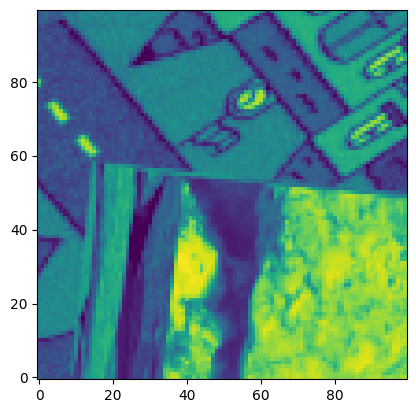

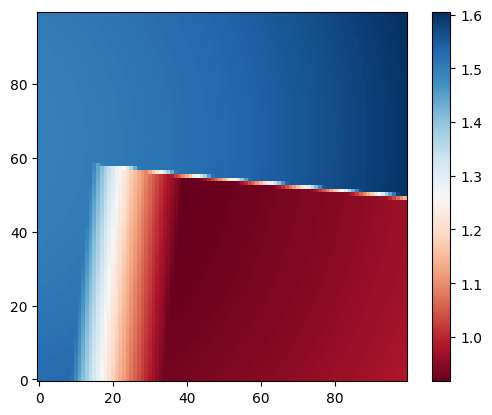

In [5]:
plt.imshow(image_intensity, origin='lower')
plt.show()

fig, (ax1) = plt.subplots(ncols=1)
image_show = ax1.imshow(image_depth, origin='lower', cmap='RdBu')
cbar = fig.colorbar(image_show, ax=ax1)
plt.show()

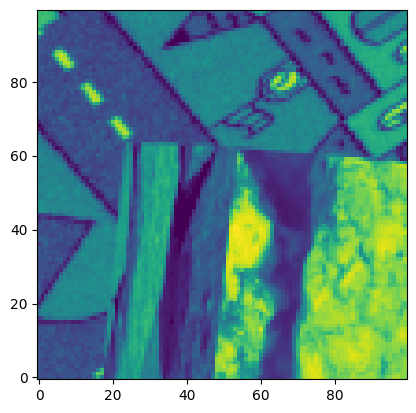

In [6]:
image_id = 200

intensity_fname = info_intensity_images[info_intensity_images['image_id'] == image_id]['path_to_img'].values[0]
image_intensity_template = read_as_grayscale(str(root_data / intensity_fname))

image_intensity_template = image_intensity_template[200:300, 300:400]

plt.imshow(image_intensity_template, origin='lower')
plt.show()

In [7]:
camera_params_path = './datasets/Multi-FoV/info/intrinsics copy.txt'
with open(camera_params_path) as f: 
    data = f.read() 
    data = data.split('=')[-1]
    
    K = np.array(eval(data))

In [8]:
K

array([[329.11552005,   0.        ,   0.        ],
       [  0.        , 329.11552005,   0.        ],
       [  0.        ,   0.        ,   1.        ]])

In [9]:
method, params = image_aligment_method(key='forward_additive')
params['alpha'] = 1.0
params['max_iterations'] = 200
params['convergence_threshold'] = 0.000001
params['p_init'] = np.array(
    [0., 0., 0., 0., 0., 0.],
    dtype=np.float32
)


transform = ReprojectionTransformation(p_init=params['p_init'], intrinsic=K.reshape(-1))

In [10]:
ps = method(
    image=(image_intensity, image_depth),
    template=image_intensity_template,
    coord_transform=transform,
    **params
)

iteration: 199, |∇p|=0.00389: 100%|██████████| 200/200 [00:22<00:00,  8.98it/s]


In [11]:
ps[-1]

array([-0.02237475,  0.0006219 , -0.00801321,  0.03860101, -0.01449724,
       -0.02809152])

In [18]:

transform.p = ps[-1]
       
image_transformed, depth_image = transform.apply_transformation(
    (image_intensity, image_depth), 
    shape=image_intensity.shape[:2]
)

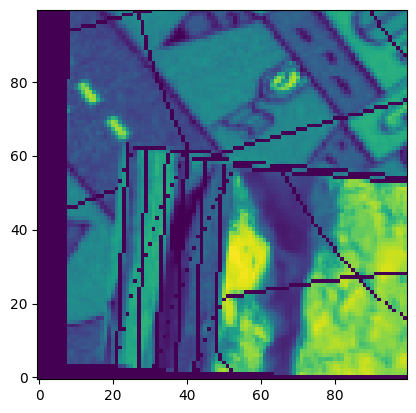

In [19]:
plt.imshow(image_transformed, origin='lower')
plt.show()

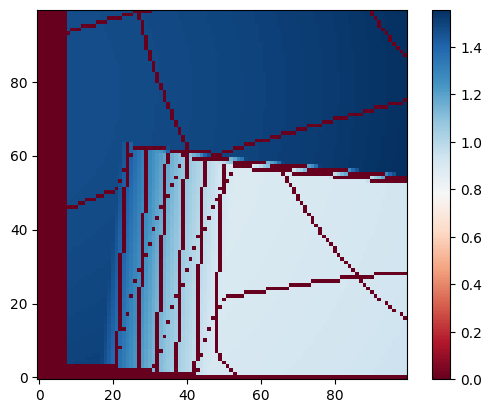

In [20]:
fig, (ax1) = plt.subplots(ncols=1)
image_show = ax1.imshow(depth_image, origin='lower', cmap='RdBu')
cbar = fig.colorbar(image_show, ax=ax1)
plt.show()

In [15]:
root_data_gt = Path('./datasets/Multi-FoV/info')
groundtruth = pd.read_csv(str(root_data_gt / 'groundtruth.txt'), names=['image_id', 'tx', 'ty', 'tz', 'qx', 'qy', 'qz', 'qw'], sep=" ")
groundtruth

,image_id,tx,ty,tz,qx,qy,qz,qw
0,1,1.499260,0.047116,1.5,0.844696,-0.529844,0.075775,0.003415
1,2,1.497040,0.094186,1.5,0.844696,-0.529844,0.075775,0.003415
2,3,1.493343,0.141162,1.5,0.844696,-0.529844,0.075775,0.003415
3,4,1.488172,0.188000,1.5,0.844696,-0.529844,0.075775,0.003415
4,5,1.481532,0.234652,1.5,0.844696,-0.529844,0.075775,0.003415
...,...,...,...,...,...,...,...,...
195,196,1.488172,-0.188000,1.5,0.844696,-0.529844,0.075775,0.003415
196,197,1.493343,-0.141162,1.5,0.844696,-0.529844,0.075775,0.003415
197,198,1.497040,-0.094186,1.5,0.844696,-0.529844,0.075775,0.003415
198,199,1.499260,-0.047116,1.5,0.844696,-0.529844,0.075775,0.003415


In [16]:
def get_relative_transformation(id_1, id_2, data: pd.DataFrame) -> np.ndarray:

    T_1 = data[data['image_id'] == id_1][['tx', 'ty', 'tz', 'qx', 'qy', 'qz', 'qw']].values[0]
    T_2 = data[data['image_id'] == id_2][['tx', 'ty', 'tz', 'qx', 'qy', 'qz', 'qw']].values[0]

    t_1 = T_1[:3]
    t_2 = T_2[:3]
    t_rel = t_2 - t_1 

    q_1 = T_1[-4:]
    q_2 = T_2[-4:]
    q_1_inv = np.copy(q_1)
    q_1_inv[:3] = (-1) * q_1_inv[:3] / np.linalg.norm(q_1)**2

    def quaternion_mult(q1: np.ndarray, q2: np.ndarray) -> np.ndarray:
        v1 = q1[:3]
        v2 = q2[:3]
        s1 = q1[-1]
        s2 = q2[-1]

        s = s1*s2 - np.dot(v1, v2)
        v = -1 * (v1*s2 + v2*s1 + np.cross(v1, v2))
        q = np.zeros(4, dtype=q1.dtype)
        q[:3] = v 
        q[-1] = s
        return q

    q_rel = quaternion_mult(q_2, q_1_inv)

    T = np.zeros(6, dtype=np.float64)
    T[-3:] = t_rel 
    T[:3] = Rotation.from_quat(q_rel).as_euler('xyz', degrees=False)
    return T

    

In [17]:
gt_p = get_relative_transformation(196, 200, groundtruth)
gt_p.round(3)

array([ 0.   , -0.   ,  0.   ,  0.011,  0.141,  0.   ])